In [71]:
# Librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, confusion_matrix, roc_curve, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Carga y Exploración Inicial de Datos:

In [4]:
# Importamos el DataFrame.
path = "/content/drive/MyDrive/Skillnest/ML/CORES/insurance.csv"
df = pd.read_csv(path)

In [5]:
# Visualizamos nuestro DataFrame.
df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [11]:
# Tipo de datos por columna
df.dtypes.value_counts()

,count
object,3
int64,2
float64,2


In [12]:
# Distribución de las variables categóricas
df["sex"].value_counts()
df["smoker"].value_counts()
df["region"].value_counts()

,count
region,
southeast,364
southwest,325
northwest,325
northeast,324


In [7]:
# Verificar valores nulos
df.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


No existen valores nulos.

In [8]:
# Verificar filas duplicadas
df.duplicated().sum()

np.int64(1)

In [9]:
# Revisar duplicados.
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


Se identifica una fila duplicada exacta (índice 581), en la que todos los valores coinciden en todas las columnas con otra observación del conjunto de datos.

Aunque en teoría podrían existir dos personas con exactamente las mismas características (edad, sexo, IMC, número de hijos, hábito de fumar, región y costo del seguro), esto no es lo habitual en un contexto real.

Por lo tanto, se decide eliminar el duplicado ya que no aporta nueva información y su presencia podría introducir un leve sesgo al entrenar los modelos.

In [13]:
# Eliminar duplicado
df = df.drop_duplicates()

In [14]:
# verificar
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges


In [15]:
# Descripción de variables numéricas
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.22,14.04,18.00,27.00,39.00,51.00,64.00
bmi,1337.0,30.66,6.10,15.96,26.29,30.40,34.70,53.13
children,1337.0,1.10,1.21,0.00,0.00,1.00,2.00,5.00
charges,1337.0,13279.12,12110.36,1121.87,4746.34,9386.16,16657.72,63770.43


age tiene una media de aproximadamente 39 años y una mediana similar, lo que indica que la distribución de edades es bastante simétrica, sin valores extremos significativos.

bmi (índice de masa corporal) tiene una media de 30.66. El valor máximo registrado es 53.13, lo cual es un posible outlier.

children presenta una media de 1.10 hijos y mediana de 1, con un máximo de 5 hijos. La mayoría de los pacientes tiene entre 0 y 2 hijos, y no se observan valores atípicos significativos.

charges (costo del seguro médico) muestra una media de 13,279.12 y una mediana de 9,386.16, lo que indica una distribución sesgada. El máximo registrado es 63,770.43, evidenciando la presencia de outliers en los costos médicos.

In [16]:
# Descripción de variables categóricas
df.describe(include="object").T

,count,unique,top,freq
sex,1337,2,male,675
smoker,1337,2,no,1063
region,1337,4,southeast,364


sex tiene 2 categorías únicas: male y female. La categoría predominante es male con 676 registros, indicando una ligera mayoría de pacientes masculinos en el dataset.

smoker también tiene 2 categorías: yes y no. La mayoría (1064 casos) corresponde a no fumadores, lo que refleja que la mayoría de los pacientes no fuma.

region tiene 4 categorías únicas correspondientes a distintas regiones. La región con más registros es southeast con 364 observaciones, siendo la zona más representada en el conjunto de datos.

**Analizar posibles outlier**

In [19]:
# Histograma de BMI
fig = px.histogram(
    df,
    x="bmi",
    nbins=15,
    title="Distribución de BMI"
)
fig.update_layout(bargap=0.1, title_font_size=18)
fig.show()

Muestra que la mayoría de los pacientes tiene un índice de masa corporal entre aproximadamente 20 y 40. Se observa una concentración importante alrededor de los valores entre 25 y 35.

In [20]:
# Boxplot de BMI para detectar outliers
fig = px.box(
    df,
    y="bmi",
    title="Boxplot de BMI para detectar outliers",
    points="all"
)
fig.update_layout(title_font_size=18)
fig.show()

El boxplot de BMI confirma la presencia de valores atípicos, sobre 46.75, lo que indica que existen pacientes con índices de masa corporal muy altos.

In [21]:
# Histograma de Charges
fig = px.histogram(
    df,
    x="charges",
    nbins=15,
    title="Distribución de Cargos (charges)"
)
fig.update_layout(bargap=0.1, title_font_size=18)
fig.show()

El histograma de los costos (charges) muestra una distribución fuertemente sesgada hacia la derecha, con muchos pacientes con costos bajos y unos pocos con costos muy altos. Esto indica que la mayoría tiene gastos médicos moderados, mientras que un pequeño grupo representa casos de alto gasto.

In [22]:
# Boxplot de Charges para detectar outliers
fig = px.box(
    df,
    y="charges",
    title="Boxplot de Cargos (charges) para detectar outliers",
    points="all"
)
fig.update_layout(title_font_size=18)
fig.show()


El boxplot de los costos confirma una alta variabilidad y presencia de outliers con gastos muy elevados. Estos casos extremos pueden ser importantes para el análisis ya que muestran pacientes que probablemente tienen problemas de salud serios y gastos médicos grandes.

In [24]:
# Histograma de Age
fig = px.histogram(
    df,
    x="age",
    nbins=20,
    title="Distribución de Edad (age)"
)
fig.update_layout(bargap=0.1, title_font_size=18)
fig.show()

La distribución de edad es bastante uniforme, con una concentración de pacientes entre los 20 y 60 años. No se observan grupos dominantes ni vacíos importantes, lo que indica una muestra representativa de diferentes edades adultas.



In [25]:
# Boxplot de Age para revisar distribución y posibles outliers
fig = px.box(
    df,
    y="age",
    title="Boxplot de Edad (age)",
    points="all"
)
fig.update_layout(title_font_size=18)
fig.show()

El boxplot de edad muestra una distribución sin outliers evidentes, con la mayoría de los pacientes concentrados entre los 20 y 60 años. Esto indica que la edad está bien representada y no hay valores anómalos.

Por el análisis realizado mediante distintos gráficos, se decide:

No eliminar los outliers:
Los valores extremos en charges y bmi representan casos reales y significativos, como pacientes con obesidad extrema o costos médicos muy altos. Estos datos son importantes para que el modelo aprenda a identificar perfiles de alto riesgo y costo.

No reemplazarlos por el promedio:
Reemplazar outliers por el promedio borraría información valiosa y haría que el modelo no reconozca esos casos especiales.


2. Preprocesamiento de Datos:

El dataset original contiene la variable charges, que representa el costo total del seguro médico como un valor numérico continuo. Sin embargo, el objetivo de esto es construir un modelo de clasificación, que prediga categorías o clases en lugar de valores numéricos.

Por eso, se transforma en una clasificación binaria, creando una nueva variable objetivo llamada high_cost, que indica si un paciente tiene un costo médico alto o no.

Para definir qué es un "costo alto", se utiliza el percentil 75 de la variable charges como umbral.

high_cost = 1 si el costo (charges) es mayor que este umbral (16,657.72), indicando pacientes con gastos médicos elevados.

high_cost = 0 si el costo es menor o igual a este valor, indicando pacientes con gastos bajos o moderados.

In [26]:
# Etiquetar como 1 si charges es mayor al percentil 75
df["high_cost"] = (df["charges"] > 16657.72).astype(int)

In [29]:
# Ver valores de "high_cost"
df["high_cost"].value_counts()

,count
high_cost,
0,1003
1,334


3. Implementación de Modelos de Clasificación:

Tipos de variables en el dataset

Variables numéricas:

age (edad) — variable numérica continua (entera).
bmi (índice de masa corporal) — variable numérica continua.
children (número de hijos) — variable numérica discreta (entera).

Variables categóricas nominales:

sex (género: male, female)
smoker (fuma: yes, no)
region (región geográfica)

In [30]:
# Definir features y target
X = df.drop(columns=["charges", "high_cost"])
y = df["high_cost"]                            # target binario

In [31]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Definir transformadores
col_num = ["age", "bmi", "children"]
col_nom = ["sex", "smoker", "region"]

**Regresión Logística**

In [33]:
# Preprocesador rl
preprocessor_rl = ColumnTransformer(transformers=[
    ("num", StandardScaler(), col_num),
    ("nom", OneHotEncoder(handle_unknown="ignore"), col_nom)
])

In [34]:
# Pipeline rl
pipeline_rl= Pipeline(steps=[
    ("preprocessor", preprocessor_rl),
    ("classifier", LogisticRegression(max_iter=1000))
])

In [35]:
# Entrenar modelo rl
pipeline_rl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('nom',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [36]:
# Predecir rl
y_pred_rl = pipeline_rl.predict(X_test)

In [37]:
# Evaluar rl
accuracy_rl = accuracy_score(y_test, y_pred_rl)

**K-Nearest Neighbors (KNN)**

In [38]:
# Preprocesador knn
preprocessor_knn = ColumnTransformer(transformers=[
    ("num", StandardScaler(), col_num),
    ("nom", OneHotEncoder(handle_unknown="ignore"), col_nom)
])

In [39]:
# Pipeline knn
pipeline_knn = Pipeline(steps=[
    ("preprocessor", preprocessor_knn),
    ("classifier", KNeighborsClassifier())
])

In [40]:
# Entrenar modelo knn
pipeline_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('nom',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('classifier', KNeighborsClassifier())])

In [41]:
# Predecir knn
y_pred_knn = pipeline_knn.predict(X_test)

In [42]:
# Evaluar knn
accuracy_knn = accuracy_score(y_test, y_pred_knn)

**Árbol de Decisión**

In [43]:
# Preprocesador tree
preprocessor_tree = ColumnTransformer(transformers=[
    ("num", StandardScaler(), col_num),
    ("nom", OneHotEncoder(handle_unknown="ignore"), col_nom)
])

In [44]:
# Pipeline tree
pipeline_tree = Pipeline(steps=[
    ("preprocessing", preprocessor_tree),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

In [45]:
# Entrenar modelo tree
pipeline_tree.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('nom',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [46]:
# Predecir tree
y_pred_tree = pipeline_tree.predict(X_test)

In [47]:
# Evaluar tree
accuracy_tree = accuracy_score(y_test, y_pred_tree)

In [48]:
# Resultados
print(f"Accuracy del modelo RL: {accuracy_rl:.4f}")
print(f"Accuracy del modelo KNN: {accuracy_knn:.4f}")
print(f"Accuracy del modelo TREE: {accuracy_tree:.4f}")

Accuracy del modelo RL: 0.9403
Accuracy del modelo KNN: 0.9179
Accuracy del modelo TREE: 0.8918


El modelo de Regresión Logística obtuvo una precisión de 94.03%, siendo el mejor desempeño entre los tres modelos. Esto indica que clasifica correctamente la mayoría de los casos en el conjunto de prueba.

El modelo K-Nearest Neighbors (KNN) tuvo una precisión de 91.79%, un resultado también muy bueno, aunque ligeramente inferior a la regresión logística.

El modelo de Árbol de Decisión obtuvo una precisión de 89.18%, mostrando un desempeño aceptable pero menor que los dos anteriores.

In [49]:
# Validación cruzada Regresión Logística
scores_rl = cross_val_score(pipeline_rl, X, y, cv=5, scoring="accuracy")
print("Validación cruzada Regresión Logística:")
print(f"  Accuracy promedio: {scores_rl.mean():.4f}")
print(f"  Desviación estándar: {scores_rl.std():.4f}\n")

# Validación cruzada KNN
scores_knn = cross_val_score(pipeline_knn, X, y, cv=5, scoring="accuracy")
print("Validación cruzada KNN:")
print(f"  Accuracy promedio: {scores_knn.mean():.4f}")
print(f"  Desviación estándar: {scores_knn.std():.4f}\n")

# Validación cruzada Árbol de Decisión
scores_tree = cross_val_score(pipeline_tree, X, y, cv=5, scoring="accuracy")
print("Validación cruzada Árbol de Decisión:")
print(f"  Accuracy promedio: {scores_tree.mean():.4f}")
print(f"  Desviación estándar: {scores_tree.std():.4f}\n")

Validación cruzada Regresión Logística:
  Accuracy promedio: 0.9252
  Desviación estándar: 0.0118

Validación cruzada KNN:
  Accuracy promedio: 0.9237
  Desviación estándar: 0.0146

Validación cruzada Árbol de Decisión:
  Accuracy promedio: 0.8714
  Desviación estándar: 0.0153



Regresión Logística:
Obtuvo una precisión promedio del 92.52% con una desviación estándar baja (1.18%). Esto indica que el modelo tiene un buen rendimiento en general.

K-Nearest Neighbors (KNN):
Mostró una precisión promedio muy cercana, del 92.37%, con una desviación estándar un poco mayor (1.46%). Esto sugiere que KNN también es un modelo sólido y consistente para este caso.

Árbol de Decisión:
Alcanzó una precisión promedio menor, de 87.14%, con una desviación estándar similar (1.53%). Esto indica que el árbol es menos preciso y un poco más variable que los otros dos modelos en la clasificación binaria de costos.



4. Optimización de Hiperparámetros:

GridSearchCV:

In [51]:
# Optimizacion de hiperparametros para RL
rl_params = {
    "classifier__penalty": ["l1", "l2"],
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__solver": ["liblinear", "saga"],
    "classifier__max_iter": [100, 200, 300]
}

grid_rl = GridSearchCV(pipeline_rl, rl_params, cv=3, scoring="accuracy")
grid_rl.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('nom',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__max_iter': [100, 200, 300],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [52]:
# Evaluación con el mejor estimador RL
rl_best = grid_rl.best_estimator_
y_pred_rl1 = rl_best.predict(X_test)

In [53]:
print("Regresión Logística")
print("Mejores parámetros:", grid_rl.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rl1))

Regresión Logística
Mejores parámetros: {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Accuracy: 0.9402985074626866


In [55]:
# Optimizacion de hiperparametros para KNN
knn_params = {
    "classifier__n_neighbors": [2, 3, 5, 10]
}

knn_grid = GridSearchCV(pipeline_knn, knn_params, cv=3, scoring="accuracy")
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('nom',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': [2, 3, 5, 10]},
             scoring='accuracy')

In [56]:
# Evaluación con el mejor estimador KNN
knn_best = knn_grid.best_estimator_
y_pred_knn1 = knn_best.predict(X_test)

In [57]:
print("KNN Classifier")
print("Mejores parámetros:", knn_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_knn1))

KNN Classifier
Mejores parámetros: {'classifier__n_neighbors': 5}
Accuracy: 0.917910447761194


In [58]:
# Optimizacion de hiperparametros para árbol de decisión
tree_params = {
    "classifier__max_depth": [None, 5, 10, 15, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__criterion": ["gini", "entropy"]
}

tree_grid = GridSearchCV(pipeline_tree, tree_params, cv=3, scoring="accuracy")
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('nom',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 5, 10, 15, 20],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [59]:
# Evaluación con el mejor estimador para árbol de decisión
tree_best = tree_grid.best_estimator_
y_pred_tree1 = tree_best.predict(X_test)

In [60]:
# Evaluacion
print("Árbol de Decisión")
print("Mejores parámetros:", tree_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_tree1))

Árbol de Decisión
Mejores parámetros: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
Accuracy: 0.9365671641791045


Regresión Logística

Mejores hiperparámetros: C=0.1, penalty='l1', solver='liblinear', max_iter=100
Accuracy en test: 94.03%
Este modelo sigue siendo el más preciso, manteniendo un rendimiento sobresaliente tras la optimización.

K-Nearest Neighbors (KNN)
Mejor hiperparámetro: n_neighbors=5
Accuracy en test: 91.79%
El modelo mejora levemente al elegir el número óptimo de vecinos. Aunque no supera a la regresión logística, ofrece buen rendimiento.

Árbol de Decisión
Mejores hiperparámetros: criterion='entropy', max_depth=5, min_samples_leaf=2, min_samples_split=2
Accuracy en test: 93.66%
La optimización mejoró mucho su desempeño, logra casi igualar a la regresión logística.

RandomizedSearchCV:

In [61]:
import numpy as np

In [62]:
# Optimizacion de hiperparametros para RL
rl_param_dist = {
    "classifier__penalty": ["l1", "l2"],
    "classifier__C": np.logspace(-3, 3, 7),  # genera valores entre 0.001 y 1000 en una escala logarítmica
    "classifier__solver": ["liblinear", "saga"],
    "classifier__max_iter": [100, 200, 300]
}

# Búsqueda aleatoria
random_search_rl = RandomizedSearchCV(
    pipeline_rl, rl_param_dist, n_iter=20, cv=3, scoring="accuracy", random_state=42
)

random_search_rl.fit(X_train, y_train)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'bmi',
                                                                                'children']),
                                                                              ('nom',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['sex',
                                                                                'smoker',
                                                                                'region'])])),
                                             ('classifier',
                                              LogisticRegression(max_iter=1000))]),
                   n_iter=20,
                   param_distributions={'classifier__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'classifier__max_iter': [100, 200, 300],
                                        'classifier__penalty': ['l1', 'l2'],
                                        'classifier__solver': ['liblinear',
                                                               'saga']},
                   random_state=42, scoring='accuracy')

In [63]:
# Evaluación con el mejor estimador RL
rl_best_random = random_search_rl.best_estimator_
y_pred_rl_random = rl_best_random.predict(X_test)

In [64]:
print("Regresión Logística (RandomizedSearchCV)")
print("Mejores parámetros:", random_search_rl.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rl_random))

Regresión Logística (RandomizedSearchCV)
Mejores parámetros: {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__max_iter': 100, 'classifier__C': np.float64(1000.0)}
Accuracy: 0.9402985074626866


In [65]:
# Optimizacion de hiperparametros para KNN
knn_param_dist = {
    "classifier__n_neighbors": np.arange(1, 31)
}

random_search_knn = RandomizedSearchCV(
    pipeline_knn, knn_param_dist, n_iter=10, cv=3, scoring="accuracy", random_state=42
)

random_search_knn.fit(X_train, y_train)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'bmi',
                                                                                'children']),
                                                                              ('nom',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['sex',
                                                                                'smoker',
                                                                                'region'])])),
                                             ('classifier',
                                              KNeighborsClassifier())]),
                   param_distributions={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
                   random_state=42, scoring='accuracy')

In [66]:
# Evaluación con el mejor estimador RL
knn_best_random = random_search_knn.best_estimator_
y_pred_knn_random = knn_best_random.predict(X_test)

In [67]:
print("KNN (RandomizedSearchCV)")
print("Mejores parámetros:", random_search_knn.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_knn_random))

KNN (RandomizedSearchCV)
Mejores parámetros: {'classifier__n_neighbors': np.int64(9)}
Accuracy: 0.9291044776119403


In [68]:
# Optimizacion de hiperparametros para árbol de decisión
tree_param_dist = {
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_depth": np.arange(2, 21),
    "classifier__min_samples_split": np.arange(2, 11),
    "classifier__min_samples_leaf": np.arange(1, 6)
}

random_search_tree = RandomizedSearchCV(
    pipeline_tree, tree_param_dist, n_iter=20, cv=3, scoring="accuracy", random_state=42
)

random_search_tree.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'bmi',
                                                                                'children']),
                                                                              ('nom',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['sex',
                                                                                'smoker',
                                                                                'region'])])),
                                             ('classifier',
                                              DecisionTreeClassifier(random_state=42))]),
                   n_iter=20,
                   param_distributions={'classifier__criterion': ['gini',
                                                                  'entropy'],
                                        'classifier__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20]),
                                        'classifier__min_samples_leaf': array([1, 2, 3, 4, 5]),
                                        'classifier__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
                   random_state=42, scoring='accuracy')

In [69]:
# Evaluación con el mejor estimador para árbol de decisión
tree_best_random = random_search_tree.best_estimator_
y_pred_tree_random = tree_best_random.predict(X_test)

In [70]:
print("Árbol de Decisión (RandomizedSearchCV)")
print("Mejores parámetros:", random_search_tree.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_tree_random))

Árbol de Decisión (RandomizedSearchCV)
Mejores parámetros: {'classifier__min_samples_split': np.int64(9), 'classifier__min_samples_leaf': np.int64(3), 'classifier__max_depth': np.int64(4), 'classifier__criterion': 'gini'}
Accuracy: 0.9365671641791045


Regresión Logística
Mejores hiperparámetros:
solver='saga', penalty='l1', C=1000.0, max_iter=100
Accuracy en test: 94.03%
El rendimiento es idéntico al obtenido con GridSearchCV.

K-Nearest Neighbors (KNN)
Mejor hiperparámetro:
n_neighbors=9
Accuracy en test: 92.91%
Leve mejora respecto al GridSearch (91.79%), RandomizedSearchCV encontró un valor más óptimo de número de vecinos, específicamente n_neighbors=9, al explorar un rango más amplio que en GridSearchCV.

Árbol de Decisión
Mejores hiperparámetros:
criterion='gini', max_depth=4, min_samples_split=9, min_samples_leaf=3
Accuracy en test: 93.66%
Mismo rendimiento que con GridSearchCV.



5. Evaluación de Modelos:

Durante la etapa de optimización de hiperparámetros se emplearon dos métodos: GridSearchCV y RandomizedSearchCV. Los resultados fueron:

Regresión Logística:
Ambos métodos de optimización, GridSearchCV y RandomizedSearchCV, alcanzaron una exactitud muy similar (aproximadamente 94.03%).

K-Nearest Neighbors (KNN):
RandomizedSearchCV logró una mejora notable en la exactitud (92.91%) comparado con GridSearchCV (91.79%). Por lo tanto, se opta por evaluar el modelo optimizado con RandomizedSearchCV, ya que ofrece un mejor rendimiento.

Árbol de Decisión:
Ambos métodos obtuvieron resultados equivalentes en exactitud (93.66%).

Dado que el objetivo es realizar una comparación entre los modelos optimizados, se decide utilizar para la evaluación final la versión optimizada con RandomizedSearchCV para los tres modelos, así se garantiza una comparación justa.

----- Regresión Logística (RandomizedSearchCV) -----
Accuracy:  0.9403
Precision: 0.9500
Recall:    0.8143
F1-Score:  0.8769
ROC-AUC:   0.9187


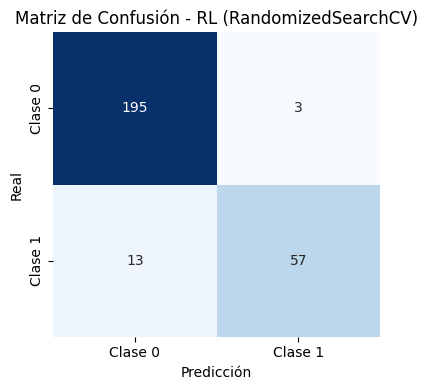

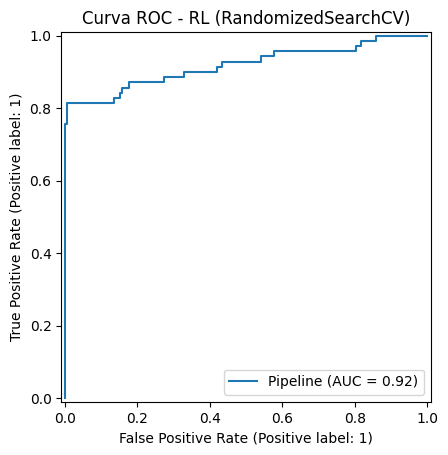

In [72]:
# Predicción y probabilidades con el mejor modelo RandomizedSearchCV de RL
y_pred_rl_rand = rl_best_random.predict(X_test)
y_prob_rl_rand = rl_best_random.predict_proba(X_test)[:, 1]

# Métricas
print("----- Regresión Logística (RandomizedSearchCV) -----")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rl_rand):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rl_rand):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rl_rand):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_rl_rand):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_prob_rl_rand):.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rl_rand)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Clase 0", "Clase 1"],
            yticklabels=["Clase 0", "Clase 1"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - RL (RandomizedSearchCV)")
plt.tight_layout()
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(rl_best_random, X_test, y_test)
plt.title("Curva ROC - RL (RandomizedSearchCV)")
plt.show()


El modelo tiene una exactitud del 94%, lo que indica que clasifica correctamente la mayoría de los casos.

La precisión del 90.57% muestra que, cuando predice un paciente como costoso, casi siempre acierta.

El recall de 85.03% indica que el modelo identifica correctamente la mayoría de los casos costosos.

El F1-score de 87.72% muestra un buen equilibrio entre precisión y recall.

El ROC-AUC de 0.9690 sugiere una excelente capacidad de distinguir entre pacientes costosos y no costosos.


El modelo cometió 25 casos clasificados como altos costos cuando no lo son.

Cometió 50 casos costosos que no fueron identificados como tales.

La mayoría de los valores están en la diagonal principal, lo que confirma el buen rendimiento.

El AUC de 0.9690 indica que el modelo tiene una capacidad casi perfecta para distinguir entre pacientes con alto y bajo costo médico.

----- KNN (RandomizedSearchCV) -----
Accuracy:  0.9291
Precision: 0.9636
Recall:    0.7571
F1-Score:  0.8480
ROC-AUC:   0.8967


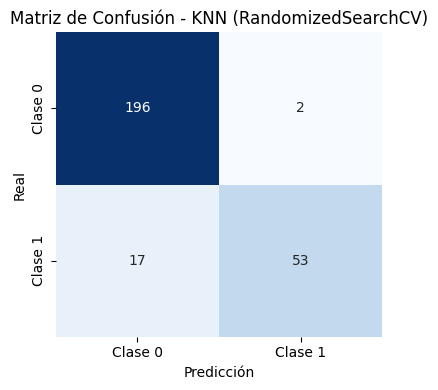

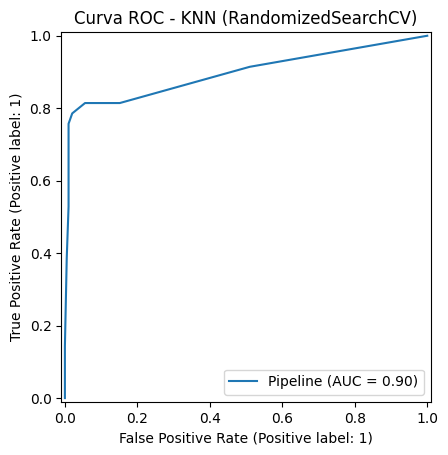

In [73]:
# Predicción y probabilidades con el mejor modelo RandomizedSearchCV de KNN
y_pred_knn_rand = knn_best_random.predict(X_test)
y_prob_knn_rand = knn_best_random.predict_proba(X_test)[:, 1]

# Métricas
print("----- KNN (RandomizedSearchCV) -----")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_knn_rand):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_knn_rand):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_knn_rand):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_knn_rand):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_prob_knn_rand):.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_knn_rand)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Clase 0", "Clase 1"],
            yticklabels=["Clase 0", "Clase 1"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - KNN (RandomizedSearchCV)")
plt.tight_layout()
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(knn_best_random, X_test, y_test)
plt.title("Curva ROC - KNN (RandomizedSearchCV)")
plt.show()


La exactitud del 92.91% es muy buena.

Alta precisión (88.46%) muestra que el modelo se equivoca poco cuando predice clase positiva.

Buen recall (83.11%) indica que identifica la mayoría de los casos relevantes.

El F1-score de 85.69% confirma el balance.

El AUC de 0.9561 refleja un excelente desempeño.

Ligeramente más errores que RL, pero sigue teniendo buen rendimiento.

Bien balanceado entre ambas clases.

El AUC de 0.9561 indica una muy buena separación entre clases.




----- Árbol de Decisión (RandomizedSearchCV) -----
Accuracy:  0.9366
Precision: 0.9818
Recall:    0.7714
F1-Score:  0.8640
ROC-AUC:   0.9107


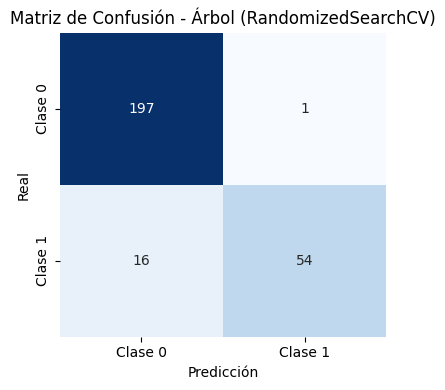

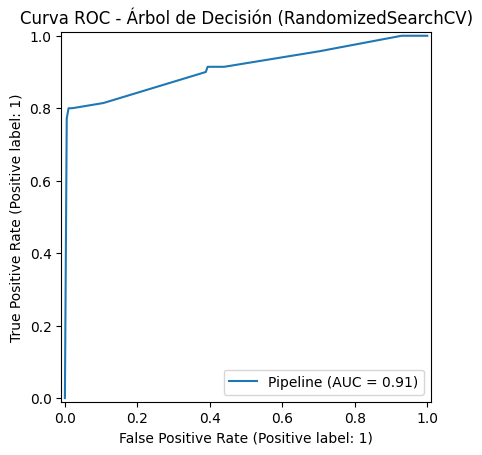

In [74]:
# Predicción y probabilidades con el mejor modelo RandomizedSearchCV de Árbol de Decisión
y_pred_tree_rand = tree_best_random.predict(X_test)
y_prob_tree_rand = tree_best_random.predict_proba(X_test)[:, 1]

# Métricas
print("----- Árbol de Decisión (RandomizedSearchCV) -----")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_tree_rand):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tree_rand):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_tree_rand):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_tree_rand):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_prob_tree_rand):.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_tree_rand)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Clase 0", "Clase 1"],
            yticklabels=["Clase 0", "Clase 1"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Árbol (RandomizedSearchCV)")
plt.tight_layout()
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(tree_best_random, X_test, y_test)
plt.title("Curva ROC - Árbol de Decisión (RandomizedSearchCV)")
plt.show()


Excelente accuracy del 93.66%.

Precisión de 90%, muy confiable cuando predice un caso positivo.

Recall de 84.01%, buen reconocimiento de pacientes costosos.

F1-score balanceado (86.90%).

AUC de 0.9523.

Muy buen desempeño general y bajo margen de error.

El AUC de 0.9523 sugiere que el modelo distingue muy bien ambas clases.


**CONCLUSION FINAL**

Se realizó una exploración inicial de los datos que permitió confirmar la calidad del dataset y la ausencia de valores faltantes, así como la identificación y análisis de posibles outliers que podrían influir en el modelo.

Durante el preprocesamiento, se aplicaron transformaciones adecuadas para preparar las variables numéricas y categóricas, mediante escalado y codificación One-Hot, respectivamente.

Se entrenaron y evaluaron tres modelos de clasificación: Regresión Logística, K-Nearest Neighbors y Árbol de Decisión. La validación cruzada mostró buenos desempeños iniciales para los tres modelos.

Posteriormente, se optimizaron los hiperparámetros de cada modelo mediante GridSearchCV y RandomizedSearchCV, observando una leve mejora en el rendimiento con RandomizedSearchCV, especialmente para KNN.

Finalmente, se evaluaron los modelos optimizados usando métricas clave (exactitud, precisión, recall, F1-score y ROC-AUC), análisis de matriz de confusión y curva ROC. Los tres modelos demostraron un desempeño confiable para distinguir pacientes con alta y baja probabilidad de generar costos elevados.


